In [ ]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install wordcloud
%pip install nltk
%pip install scikit-learn
%pip install mlxtend
%pip install unidecode


   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   --------------------------------------- 624.3/624.3 kB 11.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [607]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from unidecode import unidecode
from mlxtend.preprocessing import TransactionEncoder


In [608]:

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Admin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [755]:
df = pd.read_csv('AA_movie_train_data.csv')

In [756]:
df.head()

Title   Genre  \
0                               Windup (2006)   action   
1                               Hitman (2014)   action   
2                       Taken by Force (2010)   action   
3                      Bui doi Cho Lon (2013)   action   
4   Siam Yuth: The Dawn of the Kingdom (2015)   action   

                                         Description  
0   Windup is a very original comedy. We follow B...  
1   Rana and Shuvo, two siblings, are very differ...  
2   When a San Francisco detective goes hunting f...  
3   A man name Lam picks up his girlfriend, but i...  
4   Thap and Sin are a homeless musician brothers...

In [757]:
df['Description'].duplicated().sum()

4

In [758]:
df = df.drop_duplicates(subset='Description', keep='first')

In [759]:
df['Description'].duplicated().sum()

0

In [760]:
df[df.isnull().any(axis=1)]

Empty DataFrame
Columns: [Title, Genre, Description]
Index: []

In [761]:
df[df['Description'].duplicated()]

Empty DataFrame
Columns: [Title, Genre, Description]
Index: []

In [762]:
df = df.reset_index(drop=True)

In [763]:
df['Genre'].value_counts()

Genre
action         1000
comedy         1000
documentary    1000
thriller       1000
drama           996
Name: count, dtype: int64

In [764]:
df['Description'][0]

' Windup is a very original comedy. We follow Bernie Shaddick from his tragic childhood, through to his present day pursuit of a career as an inventor. Likened to such films as "Raising Arizona" and "The Big Lebowski", gritty cohen-esque humor saturates Bernie Shaddick\'s life, from his encounter with mace at a potential sale, to his murderous mentors posing as his Aunt Audre and Uncle Reg. Bernie is a man who, in the face of rejection and ridicule, just "doesn\'t get it", and perseveres anyways. His good nature gets on the nerves of his cruel co-workers at his commercial real estate day-job. Upholding an almost delusional enthusiasm, Bernie unknowingly sells his soul with a smile! Bernie\'s girlfriend Latrice and roommate Stuart only accentuate Bernie\'s seemingly pathetic existence. Latrice, sexy in a dirty sort of way, loves Bernie, although she would prefer to love his money, if he had any. Stuart, usually clad in underpants and obsessed with the rubix-cube, lives with Bernie becau

In [765]:
df.shape

(4996, 3)

In [766]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4996 entries, 0 to 4995
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        4996 non-null   object
 1   Genre        4996 non-null   object
 2   Description  4996 non-null   object
dtypes: object(3)
memory usage: 117.2+ KB


In [767]:
df.describe(include='object')


Title   Genre  \
count              4996    4996   
unique             4996       5   
top      Windup (2006)   action   
freq                  1    1000   

                                              Description  
count                                                4996  
unique                                               4996  
top      Windup is a very original comedy. We follow B...  
freq                                                    1

In [768]:
def get_stop_words(stop_file_path):
    with open(stop_file_path, 'r', encoding='utf-8') as f:
        custom_stopwords = set(line.strip().lower() for line in f if line.strip())
    
    return frozenset(custom_stopwords)

In [769]:
def clean_text(text):
    text = unidecode(text)                     
    text = text.lower()
    text = re.sub(r"</?.*?>", " ", text)
    text = re.sub(r"(\d|\W|_)+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [770]:
def tokenize_text(text):
    return word_tokenize(text)

In [771]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [772]:
def lemmatize_with_pos(pos_tagged_tokens):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    
    for word, tag in pos_tagged_tokens:
        pos = get_wordnet_pos(tag)  
        lemma = lemmatizer.lemmatize(word, pos)
        lemmas.append(lemma)

    return lemmas

In [773]:
stopwords = get_stop_words("stopwords.txt")

def full_text_pipeline(text, stopwords):
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    pos_tags = pos_tag(tokens)
    lemmas = lemmatize_with_pos(pos_tags)
    filtered = [lemma for lemma in lemmas if lemma not in stopwords]
    return filtered, ' '.join(filtered)


df[['description_tokens', 'description_string']] = df['Description'].apply(
    lambda x: pd.Series(full_text_pipeline(x, stopwords))
)

description_tokens = df['description_tokens'].apply(len)
description_string = df['description_string']
df[['description_string']].to_csv('processed_descriptions.csv', index=False)

In [774]:
average_tokens = description_tokens.mean()
average_tokens

68.65412329863891

In [775]:
description_string[0]

'windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gra

In [776]:
description_string.shape

(4996,)

In [777]:
bow_vectorizer = CountVectorizer(max_df=0.16, max_features=5000)
description_bow_matrix = bow_vectorizer.fit_transform(description_string.tolist())

In [778]:
sum_words = description_bow_matrix.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in bow_vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [779]:
print('The highest frequency words:')
words_freq[0:20] 

The highest frequency words:


[('woman', 1110),
 ('people', 962),
 ('kill', 943),
 ('try', 901),
 ('own', 900),
 ('father', 884),
 ('girl', 877),
 ('leave', 847),
 ('meet', 824),
 ('help', 798),
 ('home', 758),
 ('mother', 753),
 ('son', 742),
 ('wife', 735),
 ('begin', 713),
 ('start', 694),
 ('death', 671),
 ('brother', 664),
 ('police', 663),
 ('city', 659)]

In [780]:
print('The lowest frequency words:')
words_freq[-20:] 

The lowest frequency words:


[('reference', 10),
 ('peak', 10),
 ('sculpture', 10),
 ('karim', 10),
 ('mood', 10),
 ('similarity', 10),
 ('copy', 10),
 ('suppress', 10),
 ('tango', 10),
 ('assess', 10),
 ('description', 10),
 ('definition', 10),
 ('programme', 10),
 ('winemaker', 10),
 ('astonish', 10),
 ('mick', 10),
 ('toi', 10),
 ('haru', 10),
 ('sidda', 10),
 ('haunted', 10)]

In [781]:
bow_vectorizer.get_feature_names_out()

array(['aaron', 'aarti', 'abandon', ..., 'zombie', 'zone', 'zorawar'],
      dtype=object)

In [782]:
feature_names=np.array(bow_vectorizer.get_feature_names_out())
len(bow_vectorizer.get_feature_names_out())

5000

In [783]:
df_bow = pd.DataFrame(description_bow_matrix.toarray(), columns=bow_vectorizer.get_feature_names_out())
df_bow.to_csv('asg1_bow_export.csv', index=False)

### 1.4 TF-IDF

In [784]:
tfidf_transformer=TfidfTransformer(smooth_idf=True, use_idf=True)
description_tfidf = tfidf_transformer.fit_transform(description_bow_matrix)

In [785]:
tfidf_transformer.idf_

array([7.11869774, 7.72483354, 4.6803111 , ..., 5.56534929, 6.29771719,
       8.82344583])

In [786]:
tfidf_transformer.idf_.shape

(5000,)

In [787]:
sorted_by_idf = np.argsort(tfidf_transformer.idf_)
print("Features with lowest idf:\n{}".format(
       feature_names[sorted_by_idf[:100]]))

Features with lowest idf:
['woman' 'own' 'try' 'people' 'meet' 'leave' 'help' 'kill' 'begin' 'start'
 'home' 'decide' 'father' 'lead' 'girl' 'follow' 'force' 'look' 'wife'
 'death' 'set' 'name' 'tell' 'son' 'bring' 'mother' 'city' 'soon' 'run'
 'fall' 'fight' 'call' 'child' 'daughter' 'police' 'return' 'change'
 'night' 'brother' 'discover' 'murder' 'town' 'lose' 'local' 'house'
 'documentary' 'past' 'secret' 'learn' 'plan' 'school' 'play' 'move'
 'dream' 'journey' 'job' 'save' 'series' 'money' 'happen' 'struggle'
 'relationship' 'movie' 'include' 'real' 'country' 'war' 'escape' 'hand'
 'head' 'win' 'character' 'die' 'event' 'american' 'realize' 'attempt'
 'break' 'sister' 'boy' 'husband' 'student' 'dead' 'bad' 'stop' 'power'
 'human' 'team' 'true' 'age' 'little' 'question' 'experience' 'former'
 'create' 'search' 'believe' 'evil' 'drug' 'hold']


In [788]:
pd.DataFrame(description_tfidf.toarray())

0     1     2     3     4     5     6     7     8     9     ...  4990  \
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
4991   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4992   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4993   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4994   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      4991  4992  4993  4994  4995  4996  4997  4998  4999  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
4991   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4992   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4993   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4994   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4995   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[4996 rows x 5000 columns]

In [789]:
# find maximum value for each of the features over dataset:
max_value = description_tfidf.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
      feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
      feature_names[sorted_by_tfidf[-20:]]))

Features with lowest tfidf:
['pound' 'endanger' 'obsessive' 'conceal' 'tease' 'injure' 'kapoor'
 'operate' 'seriously' 'thirsty' 'flees' 'dc' 'actually' 'resemble'
 'enthusiasm' 'ensues' 'flip' 'verma' 'sand' 'behalf']
Features with highest tfidf: 
['fort' 'flint' 'axel' 'tristan' 'jo' 'bernie' 'shanichari' 'coral' 'yoga'
 'jaswant' 'devin' 'volcano' 'laundry' 'perry' 'pierre' 'sreeram' 'selma'
 'rider' 'wine' 'comme']


## 2. Text Data Understanding

### 2.1 Extract keywords using TF-IDF matrix

In [790]:
idx=0
doc = description_string[idx]
print(doc)

tf_idf_vector=description_tfidf[idx]
print(tf_idf_vector)

windup original comedy follow bernie shaddick tragic childhood day pursuit career inventor liken film raise arizona lebowski gritty cohen esque humor saturate bernie shaddick life encounter mace potential sale murderous mentor pose aunt audre uncle reg bernie rejection ridicule doesn persevere anyways nature nerve cruel co worker commercial real estate day job uphold delusional enthusiasm bernie unknowingly sell soul smile bernie girlfriend latrice roommate stuart accentuate bernie seemingly pathetic existence latrice sexy dirty sort love bernie prefer love money stuart usually clothe underpants obsess rubix cube live bernie allow pursue beer welfare check latrice myriad flashback eccentric aunt uncle learn mentor reg audre life strange habit murder meal wheel delivery boys worry bernie won inherit twisted trait aunt audre uncle reg actually squatter murder pose real family bernie dream invent product windup flashlight conjure laughter succeed conscience boy bernie hold flashlight gran

In [791]:
tf_idf_vector.shape

(1, 5000)

In [792]:
temp = pd.DataFrame(zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),columns=['feature_number','tf_idf'])
temp

feature_number    tf_idf
0               57  0.032768
1              145  0.033633
2              251  0.047570
3              324  0.173153
4              405  0.042533
..             ...       ...
94            4746  0.041639
95            4890  0.098476
96            4898  0.044444
97            4951  0.065652
98            4954  0.040309

[99 rows x 2 columns]

In [793]:
temp.sort_values('tf_idf', ascending = False, inplace = True)
temp

feature_number    tf_idf
5              434  0.854409
3              324  0.173153
92            4672  0.145359
73            3614  0.103789
87            4303  0.101252
..             ...       ...
51            2591  0.024959
19            1104  0.023866
36            1753  0.022167
38            1890  0.022130
90            4643  0.020212

[99 rows x 2 columns]

In [794]:
topn = 40
results =[]

In [795]:
results = []

for idx, row in df.iterrows():
    doc = row['description_string']
    tf_idf_vector = description_tfidf[idx]

    temp = pd.DataFrame(
        zip(tf_idf_vector.tocoo().col, tf_idf_vector.tocoo().data),
        columns=['feature_number', 'tf_idf']
    )
    temp.sort_values('tf_idf', ascending=False, inplace=True)
    topn_items = temp[:topn]

    tf_idf = []
    word = []

    for _, item in topn_items.iterrows():
        fname = feature_names[int(item['feature_number'])]
        word.append(fname)
        tf_idf.append(round(item['tf_idf'], 3))

    result = dict(zip(word, tf_idf))
    results.append(result)

df['keywords'] = results



In [796]:
len(results)

4996

In [797]:
df['keywords'] = results
df.head()

Title   Genre  \
0                               Windup (2006)   action   
1                               Hitman (2014)   action   
2                       Taken by Force (2010)   action   
3                      Bui doi Cho Lon (2013)   action   
4   Siam Yuth: The Dawn of the Kingdom (2015)   action   

                                         Description  \
0   Windup is a very original comedy. We follow B...   
1   Rana and Shuvo, two siblings, are very differ...   
2   When a San Francisco detective goes hunting f...   
3   A man name Lam picks up his girlfriend, but i...   
4   Thap and Sin are a homeless musician brothers...   

                                  description_tokens  \
0  [windup, original, comedy, follow, bernie, sha...   
1  [rana, shuvo, sibling, father, police, constab...   
2  [san, francisco, detective, hunt, cruel, asian...   
3  [name, lam, pick, girlfriend, reveal, girlfrie...   
4  [thap, sin, homeless, musician, brother, villa...   

                                  description_string  \
0  windup original comedy follow bernie shaddick ...   
1  rana shuvo sibling father police constable dea...   
2  san francisco detective hunt cruel asian crime...   
3  name lam pick girlfriend reveal girlfriend act...   
4  thap sin homeless musician brother village rai...   

                                            keywords  
0  {'bernie': 0.854, 'aunt': 0.173, 'uncle': 0.14...  
1  {'rana': 0.677, 'brother': 0.224, 'crime': 0.1...  
2  {'nelson': 0.54, 'violent': 0.221, 'detective'...  
3  {'lam': 0.744, 'gangster': 0.386, 'martial': 0...  
4  {'ram': 0.694, 'sin': 0.413, 'prince': 0.307, ...

In [798]:

token_lists = df['keywords'].apply(lambda x: list(x.keys()))


transactions_df = pd.DataFrame(token_lists.tolist())


transactions_df.to_csv('transactions.csv', index=False, header=False)

print(token_lists)


0       [bernie, aunt, uncle, real, stuart, welfare, c...
1       [rana, brother, crime, bravery, extent, police...
2       [nelson, violent, detective, asian, francisco,...
3       [lam, gangster, martial, artist, girlfriend, b...
4       [ram, sin, prince, kingdom, village, plan, con...
                              ...                        
4991    [danielle, rachel, jeff, heart, organ, donatio...
4992    [max, driver, car, allure, psychopathic, distu...
4993    [jimmy, wood, monster, claim, spend, night, pr...
4994    [sean, victim, killer, die, fight, captive, sc...
4995    [skip, sage, play, recollection, devious, chil...
Name: keywords, Length: 4996, dtype: object


### 2.2 Association Rules Mining on keywords

In [799]:
transactions = pd.read_csv("transactions.csv", header=None)
transactions.head()

0         1          2        3           4        5            6   \
0  bernie      aunt      uncle     real      stuart  welfare        cuban   
1    rana   brother      crime  bravery      extent   police       shower   
2  nelson   violent  detective    asian   francisco   device          san   
3     lam  gangster    martial   artist  girlfriend  brother         kill   
4     ram       sin     prince  kingdom     village     plan  controversy   

          7       8        9   ...     30      31            32      33  \
0     invent  mentor  product  ...   meal  prefer      motivate   death   
1       tall  tackle  promote  ...  catch   stand          fear  battle   
2  terrorist  center  capture  ...    sit   china           air     isn   
3    furious   fight     trap  ...   send    evil  relationship   learn   
4  residence    stir     raid  ...    try     NaN           NaN     NaN   

            34        35       36      37     38      39  
0  unknowingly  delivery    bunch   habit  wheel  gritty  
1          win     fight    death  father    NaN     NaN  
2       assign      jack  angeles     los    gun  weapon  
3         tell      name     girl    lead  leave     try  
4          NaN       NaN      NaN     NaN    NaN     NaN  

[5 rows x 40 columns]

In [ ]:

transactions = df['keywords'].apply(lambda x: list(x.keys())).tolist()

te = TransactionEncoder()
data_encoded = te.fit_transform(transactions)

data_encoded_df = pd.DataFrame(data_encoded, columns=te.columns_)

# Check shape
print(data_encoded_df.shape)


[['bernie',
  'aunt',
  'uncle',
  'real',
  'stuart',
  'welfare',
  'cuban',
  'invent',
  'mentor',
  'product',
  'commercial',
  'pose',
  'estate',
  'co',
  'worker',
  'deal',
  'mace',
  'grandma',
  'money',
  'dream',
  'laughter',
  'pin',
  'rejection',
  'murder',
  'myriad',
  'smile',
  'arizona',
  'enthusiasm',
  'conscience',
  'boys',
  'meal',
  'prefer',
  'motivate',
  'death',
  'unknowingly',
  'delivery',
  'bunch',
  'habit',
  'wheel',
  'gritty'],
 ['rana',
  'brother',
  'crime',
  'bravery',
  'extent',
  'police',
  'shower',
  'tall',
  'tackle',
  'promote',
  'villain',
  'arise',
  'assume',
  'sibling',
  'brave',
  'onto',
  'assist',
  'elder',
  'duty',
  'courage',
  'brutally',
  'lack',
  'overcome',
  'guard',
  'difficult',
  'step',
  'cop',
  'hunt',
  'build',
  'due',
  'catch',
  'stand',
  'fear',
  'battle',
  'win',
  'fight',
  'death',
  'father'],
 ['nelson',
  'violent',
  'detective',
  'asian',
  'francisco',
  'device',
  'san

In [ ]:

keyword_counts = data_encoded_df.sum().sort_values(ascending=False)

top_keywords = keyword_counts.head(100).index

data_encoded_filtered = data_encoded_df[top_keywords]


In [803]:
print(data_encoded_filtered.sum(axis=1).mean())

5.126301040832666


In [804]:
data_encoded_filtered.shape

(4996, 100)

In [805]:
data_encoded_filtered

woman    try  people    own   kill  leave   girl   meet  father   help  \
0     False  False   False  False  False  False  False  False   False  False   
1     False  False   False  False  False  False  False  False    True  False   
2     False  False   False  False  False  False  False  False   False  False   
3     False   True   False  False   True   True   True  False   False  False   
4     False   True   False  False  False  False  False   True   False  False   
...     ...    ...     ...    ...    ...    ...    ...    ...     ...    ...   
4991  False  False   False  False  False  False  False  False    True  False   
4992  False  False   False  False  False  False  False  False   False  False   
4993  False  False   False  False  False   True  False  False   False  False   
4994  False   True   False  False  False  False  False  False   False  False   
4995  False  False   False  False  False  False  False  False   False  False   

      ...   game  marry  mysterious    art    bad  former   dead  little  \
0     ...  False  False       False  False  False   False  False   False   
1     ...  False  False       False  False  False   False  False   False   
2     ...  False  False       False   True  False   False  False   False   
3     ...  False  False       False  False  False   False  False   False   
4     ...  False  False       False  False  False   False  False   False   
...   ...    ...    ...         ...    ...    ...     ...    ...     ...   
4991  ...  False  False       False  False  False   False  False   False   
4992  ...  False  False       False  False  False   False  False   False   
4993  ...  False  False       False  False  False   False  False   False   
4994  ...  False  False       False  False  False   False  False   False   
4995  ...   True  False       False  False  False   False  False   False   

      beautiful  history  
0         False    False  
1         False    False  
2         False    False  
3         False    False  
4         False    False  
...         ...      ...  
4991      False    False  
4992      False    False  
4993      False    False  
4994      False    False  
4995      False    False  

[4996 rows x 100 columns]

In [806]:
for support in [0.05, 0.01, 0.005, 0.003, 0.002]:
    itemsets = apriori(data_encoded_filtered, min_support=support, use_colnames=True)
    print(f"Support: {support}, Itemsets: {itemsets.shape[0]}")

Support: 0.05, Itemsets: 45
Support: 0.01, Itemsets: 139
Support: 0.005, Itemsets: 773
Support: 0.003, Itemsets: 2320
Support: 0.002, Itemsets: 3939


In [807]:
frequent_itemsets=apriori(data_encoded_filtered, min_support = 0.002, use_colnames = True)

In [808]:
frequent_itemsets[['support']].describe()

support
count  3939.000000
mean      0.004874
std       0.008002
min       0.002002
25%       0.002402
50%       0.003203
75%       0.004404
max       0.103082

In [809]:
frequent_itemsets

support                  itemsets
0     0.103082                   (woman)
1     0.088070                     (try)
2     0.086069                  (people)
3     0.080264                     (own)
4     0.078463                    (kill)
...        ...                       ...
3934  0.002202    (son, daughter, marry)
3935  0.002002        (son, name, marry)
3936  0.002202  (brother, death, police)
3937  0.002802  (police, killer, murder)
3938  0.002002   (brother, sister, fall)

[3939 rows x 2 columns]

In [825]:
rules_l = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules_l

antecedents        consequents  antecedent support  \
0             (woman)              (try)            0.103082   
1               (try)            (woman)            0.088070   
2             (woman)           (people)            0.103082   
3            (people)            (woman)            0.086069   
4             (woman)              (own)            0.103082   
...               ...                ...                 ...   
6951  (brother, fall)           (sister)            0.006605   
6952   (sister, fall)          (brother)            0.005404   
6953        (brother)     (sister, fall)            0.056445   
6954         (sister)    (brother, fall)            0.045236   
6955           (fall)  (brother, sister)            0.055244   

      consequent support   support  confidence      lift  representativity  \
0               0.088070  0.011209    0.108738  1.234669               1.0   
1               0.103082  0.011209    0.127273  1.234669               1.0   
2               0.086069  0.009408    0.091262  1.060339               1.0   
3               0.103082  0.009408    0.109302  1.060339               1.0   
4               0.080264  0.010008    0.097087  1.209597               1.0   
...                  ...       ...         ...       ...               ...   
6951            0.045236  0.002002    0.303030  6.698847               1.0   
6952            0.056445  0.002002    0.370370  6.561597               1.0   
6953            0.005404  0.002002    0.035461  6.561597               1.0   
6954            0.006605  0.002002    0.044248  6.698847               1.0   
6955            0.007206  0.002002    0.036232  5.028180               1.0   

      leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0     0.002130    1.023189       0.211911  0.062291   0.022663    0.118005  
1     0.002130    1.027718       0.208422  0.062291   0.026970    0.118005  
2     0.000535    1.005715       0.063445  0.052339   0.005682    0.100282  
3     0.000535    1.006983       0.062264  0.052339   0.006935    0.100282  
4     0.001734    1.018632       0.193193  0.057737   0.018291    0.110888  
...        ...         ...            ...       ...        ...         ...  
6951  0.001703    1.369879       0.856377  0.040161   0.270008    0.173639  
6952  0.001697    1.498587       0.852204  0.033445   0.332705    0.202916  
6953  0.001697    1.031162       0.898303  0.033445   0.030220    0.202916  
6954  0.001703    1.039385       0.891027  0.040161   0.037893    0.173639  
6955  0.001604    1.030117       0.847966  0.033113   0.029237    0.157005  

[6956 rows x 14 columns]

In [ ]:
rules_filtered = rules_l[(rules_l['lift'] > 5) & (rules_l['confidence'] > 0.3)]
rules_filtered.sort_values(by='lift', ascending=False)
rules_filtered.to_csv("ARM_Export_LIFT")


antecedents  consequents  antecedent support  consequent support  \
6932       (son, name)      (marry)            0.005204            0.036229   
6572      (wife, girl)      (marry)            0.005604            0.036229   
6164     (woman, name)  (beautiful)            0.008006            0.035028   
6176   (woman, killer)     (murder)            0.005204            0.055044   
6844     (death, home)     (return)            0.005204            0.051841   
...                ...          ...                 ...                 ...   
6717    (mother, soon)     (father)            0.005204            0.075861   
6921    (son, husband)   (daughter)            0.007006            0.062250   
6747     (mother, die)     (father)            0.006805            0.075861   
6938  (brother, death)     (police)            0.007206            0.060649   
6796   (father, begin)   (daughter)            0.006405            0.062250   

       support  confidence       lift  representativity  leverage  conviction  \
6932  0.002002    0.384615  10.616235               1.0  0.001813    1.566128   
6572  0.002002    0.357143   9.857932               1.0  0.001799    1.499199   
6164  0.002602    0.325000   9.278286               1.0  0.002322    1.429588   
6176  0.002602    0.500000   9.083636               1.0  0.002316    1.889912   
6844  0.002402    0.461538   8.902881               1.0  0.002132    1.760866   
...        ...         ...        ...               ...       ...         ...   
6717  0.002002    0.384615   5.070022               1.0  0.001607    1.501726   
6921  0.002202    0.314286   5.048783               1.0  0.001766    1.367552   
6747  0.002602    0.382353   5.040199               1.0  0.002086    1.496226   
6938  0.002202    0.305556   5.038137               1.0  0.001765    1.352666   
6796  0.002002    0.312500   5.020096               1.0  0.001603    1.364000   

      zhangs_metric   jaccard  certainty  kulczynski  
6932       0.910543  0.050761   0.361483    0.219932  
6572       0.903623  0.050251   0.332977    0.206196  
6164       0.899423  0.064356   0.300498    0.199643  
6176       0.894567  0.045139   0.470875    0.273636  
6844       0.892321  0.043956   0.432098    0.253935  
...             ...       ...        ...         ...  
6717       0.806962  0.025316   0.334100    0.205500  
6921       0.807590  0.032836   0.268767    0.174828  
6747       0.807088  0.032500   0.331652    0.208327  
6938       0.807331  0.033537   0.260719    0.170930  
6796       0.805963  0.030030   0.266862    0.172327  

[71 rows x 14 columns]

In [ ]:
rules_filtered.sort_values(by='confidence', ascending=False)
rules_filtered.to_csv("ARM_Export_CONFIDENCE")


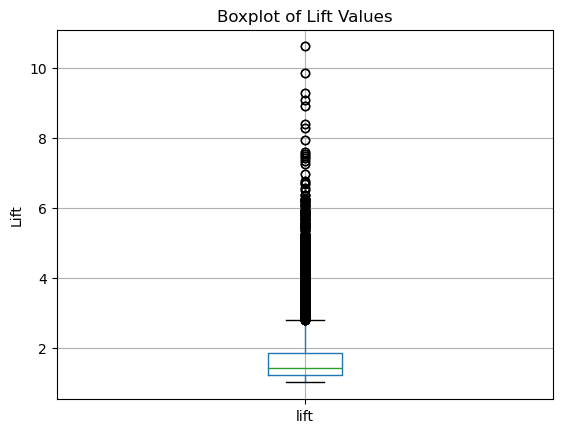

In [828]:
rules_l[['lift']].boxplot()
plt.title("Boxplot of Lift Values")
plt.ylabel("Lift")
plt.show()

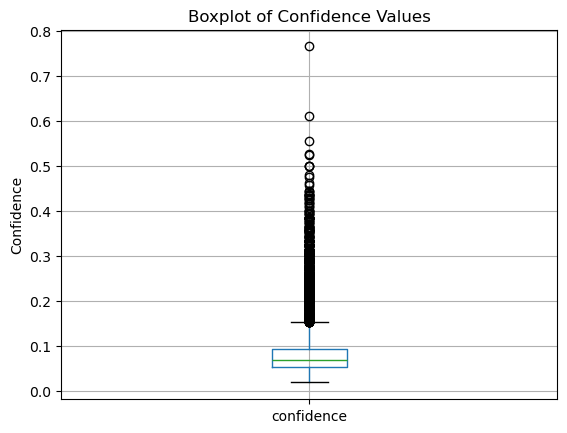

In [830]:
rules_l[['confidence']].boxplot()
plt.title("Boxplot of Confidence Values")
plt.ylabel("Confidence")
plt.show()

In [814]:
df

Title     Genre  \
0                                     Windup (2006)     action   
1                                     Hitman (2014)     action   
2                             Taken by Force (2010)     action   
3                            Bui doi Cho Lon (2013)     action   
4         Siam Yuth: The Dawn of the Kingdom (2015)     action   
...                                              ...       ...   
4991                          The Harvesters (2000)   thriller   
4992                                    PRND (2017)   thriller   
4993   Jimmy Tupper vs. the Goatman of Bowie (2010)   thriller   
4994                 Captive of a Death Mask (2012)   thriller   
4995                               Locker 13 (2014)   thriller   

                                            Description  \
0      Windup is a very original comedy. We follow B...   
1      Rana and Shuvo, two siblings, are very differ...   
2      When a San Francisco detective goes hunting f...   
3      A man name Lam picks up his girlfriend, but i...   
4      Thap and Sin are a homeless musician brothers...   
...                                                 ...   
4991   Danielle Carver has inherited the same heart ...   
4992   When Max has a disturbing incident with a dri...   
4993   Jimmy Tupper is a no one, he's nothing. He sp...   
4994   The only one more scared than his victims is ...   
4995   Skip, the nighttime janitor in an Old West th...   

                                     description_tokens  \
0     [windup, original, comedy, follow, bernie, sha...   
1     [rana, shuvo, sibling, father, police, constab...   
2     [san, francisco, detective, hunt, cruel, asian...   
3     [name, lam, pick, girlfriend, reveal, girlfrie...   
4     [thap, sin, homeless, musician, brother, villa...   
...                                                 ...   
4991  [danielle, carver, inherit, heart, disease, mo...   
4992  [max, disturbing, incident, driver, transporta...   
4993  [jimmy, tupper, spend, day, starbucks, suburba...   
4994  [scar, victim, killer, underground, fighter, s...   
4995  [skip, nighttime, janitor, west, theme, park, ...   

                                     description_string  \
0     windup original comedy follow bernie shaddick ...   
1     rana shuvo sibling father police constable dea...   
2     san francisco detective hunt cruel asian crime...   
3     name lam pick girlfriend reveal girlfriend act...   
4     thap sin homeless musician brother village rai...   
...                                                 ...   
4991  danielle carver inherit heart disease mother d...   
4992  max disturbing incident driver transportation ...   
4993  jimmy tupper spend day starbucks suburban mary...   
4994  scar victim killer underground fighter sean po...   
4995  skip nighttime janitor west theme park delve m...   

                                               keywords  
0     {'bernie': 0.854, 'aunt': 0.173, 'uncle': 0.14...  
1     {'rana': 0.677, 'brother': 0.224, 'crime': 0.1...  
2     {'nelson': 0.54, 'violent': 0.221, 'detective'...  
3     {'lam': 0.744, 'gangster': 0.386, 'martial': 0...  
4     {'ram': 0.694, 'sin': 0.413, 'prince': 0.307, ...  
...                                                 ...  
4991  {'danielle': 0.525, 'rachel': 0.454, 'jeff': 0...  
4992  {'max': 0.594, 'driver': 0.364, 'car': 0.204, ...  
4993  {'jimmy': 0.689, 'wood': 0.305, 'monster': 0.2...  
4994  {'sean': 0.514, 'victim': 0.227, 'killer': 0.2...  
4995  {'skip': 0.362, 'sage': 0.199, 'play': 0.19, '...  

[4996 rows x 6 columns]

# OTHER METHODS

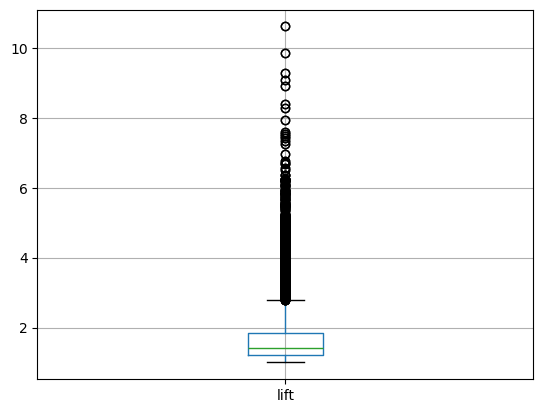

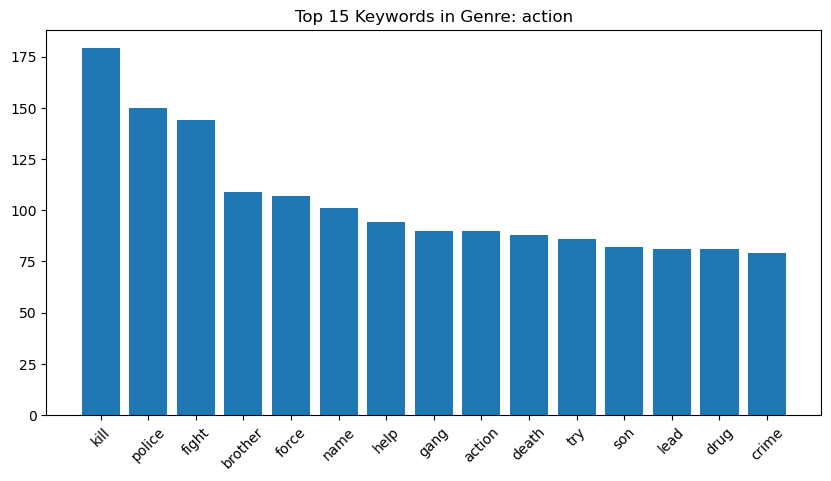

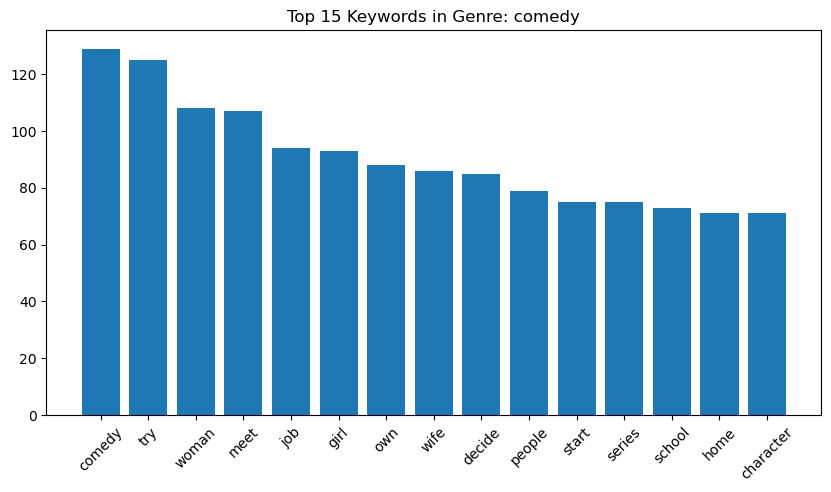

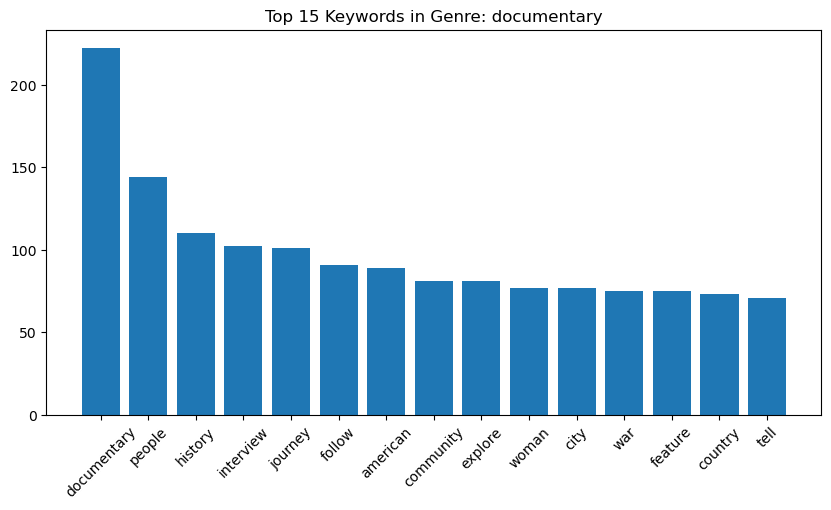

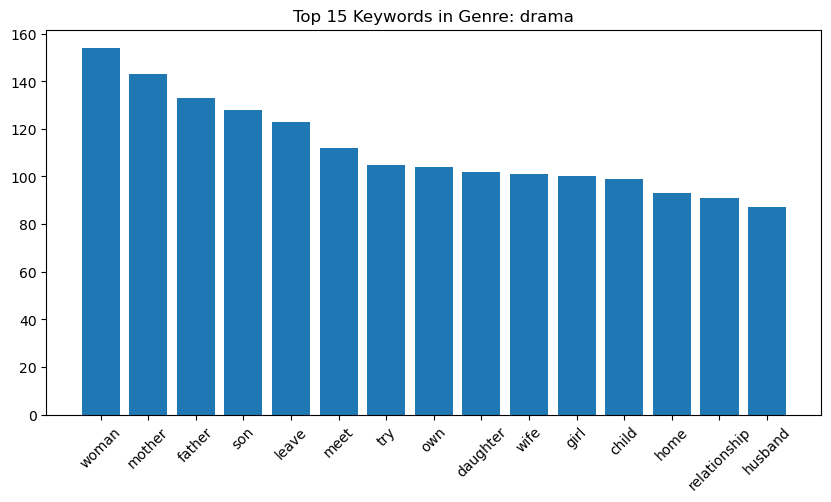

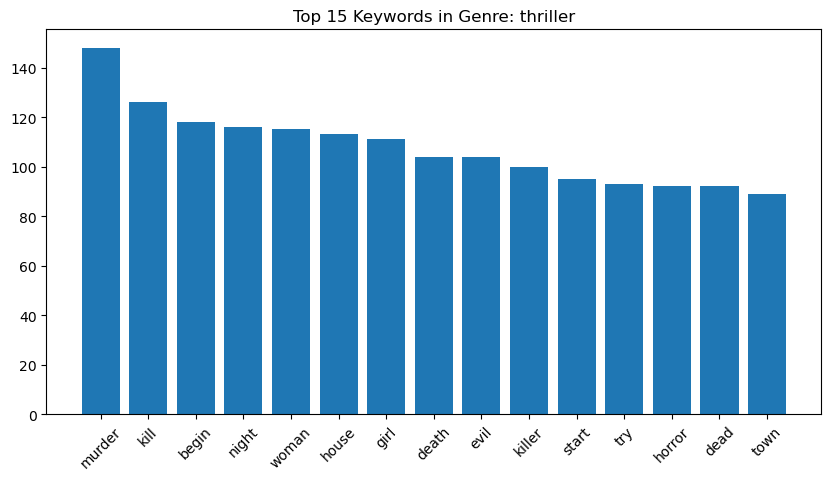

In [815]:
import matplotlib.pyplot as plt
from collections import Counter

# Assume df['keywords'] contains dict of {word: tfidf_score} for each movie
genres = df['Genre'].unique()

for genre in genres:
    # Get all keywords for movies in this genre
    genre_keywords = df[df['Genre'] == genre]['keywords'].tolist()
    
    # Flatten all keywords into a list (ignore tfidf, just use keys)
    all_words = [word for d in genre_keywords for word in d.keys()]
    
    # Count frequency of keywords
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(15)
    
    words, counts = zip(*common_words)
    
    plt.figure(figsize=(10,5))
    plt.bar(words, counts)
    plt.title(f"Top 15 Keywords in Genre: {genre}")
    plt.xticks(rotation=45)
    plt.show()


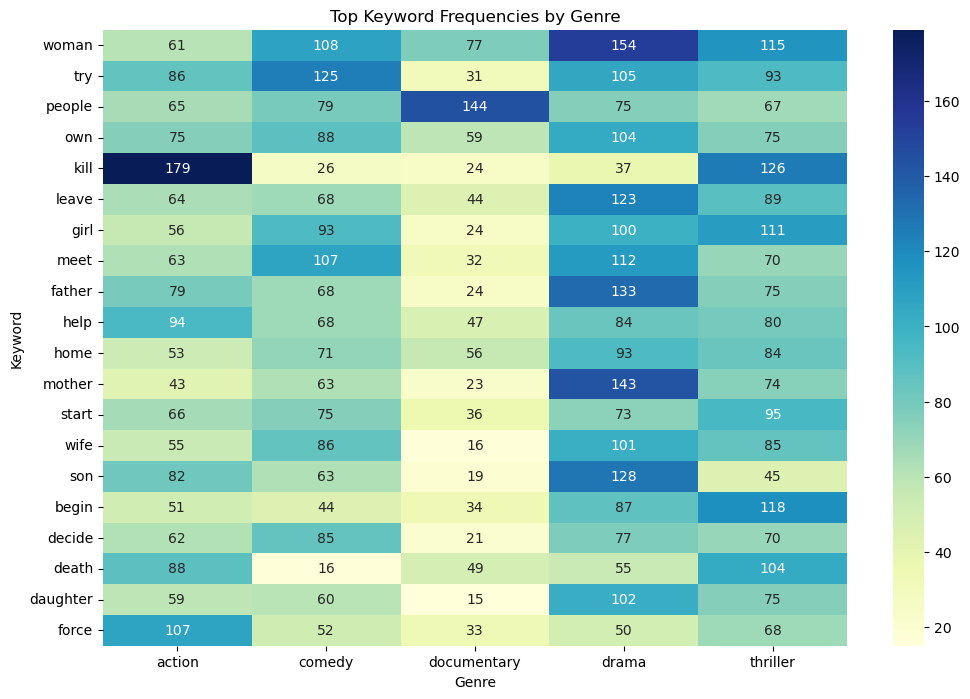

In [816]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten all keywords with their genres
genre_keyword_counts = {}

for genre in df['Genre'].unique():
    keyword_dicts = df[df['Genre'] == genre]['keywords'].tolist()
    all_keywords = []
    for kw_dict in keyword_dicts:
        all_keywords.extend(kw_dict.keys())
    genre_keyword_counts[genre] = pd.Series(all_keywords).value_counts()

# Create DataFrame from dict of Series
genre_keyword_df = pd.DataFrame(genre_keyword_counts).fillna(0)

# Select top 20 keywords overall to keep heatmap readable
top_keywords = genre_keyword_df.sum(axis=1).sort_values(ascending=False).head(20).index
top_keywords_df = genre_keyword_df.loc[top_keywords]

plt.figure(figsize=(12,8))
sns.heatmap(top_keywords_df, annot=True, fmt='g', cmap='YlGnBu')
plt.title('Top Keyword Frequencies by Genre')
plt.xlabel('Genre')
plt.ylabel('Keyword')
plt.show()


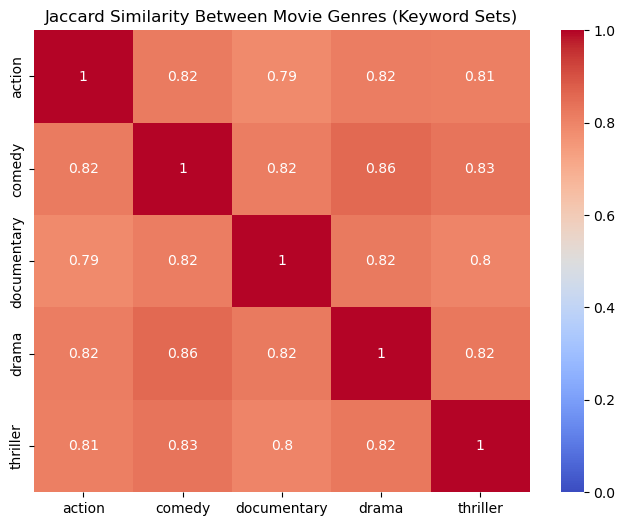

In [817]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

genres = df['Genre'].unique()
genre_keywords_sets = {}

# Create a set of unique keywords per genre
for genre in genres:
    all_words = [word for d in df[df['Genre'] == genre]['keywords'].tolist() for word in d.keys()]
    genre_keywords_sets[genre] = set(all_words)

# Build similarity matrix
sim_matrix = np.zeros((len(genres), len(genres)))

for i, g1 in enumerate(genres):
    for j, g2 in enumerate(genres):
        sim_matrix[i, j] = jaccard_similarity(genre_keywords_sets[g1], genre_keywords_sets[g2])

# Convert to DataFrame for better plotting
sim_df = pd.DataFrame(sim_matrix, index=genres, columns=genres)

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(sim_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Jaccard Similarity Between Movie Genres (Keyword Sets)')
plt.show()


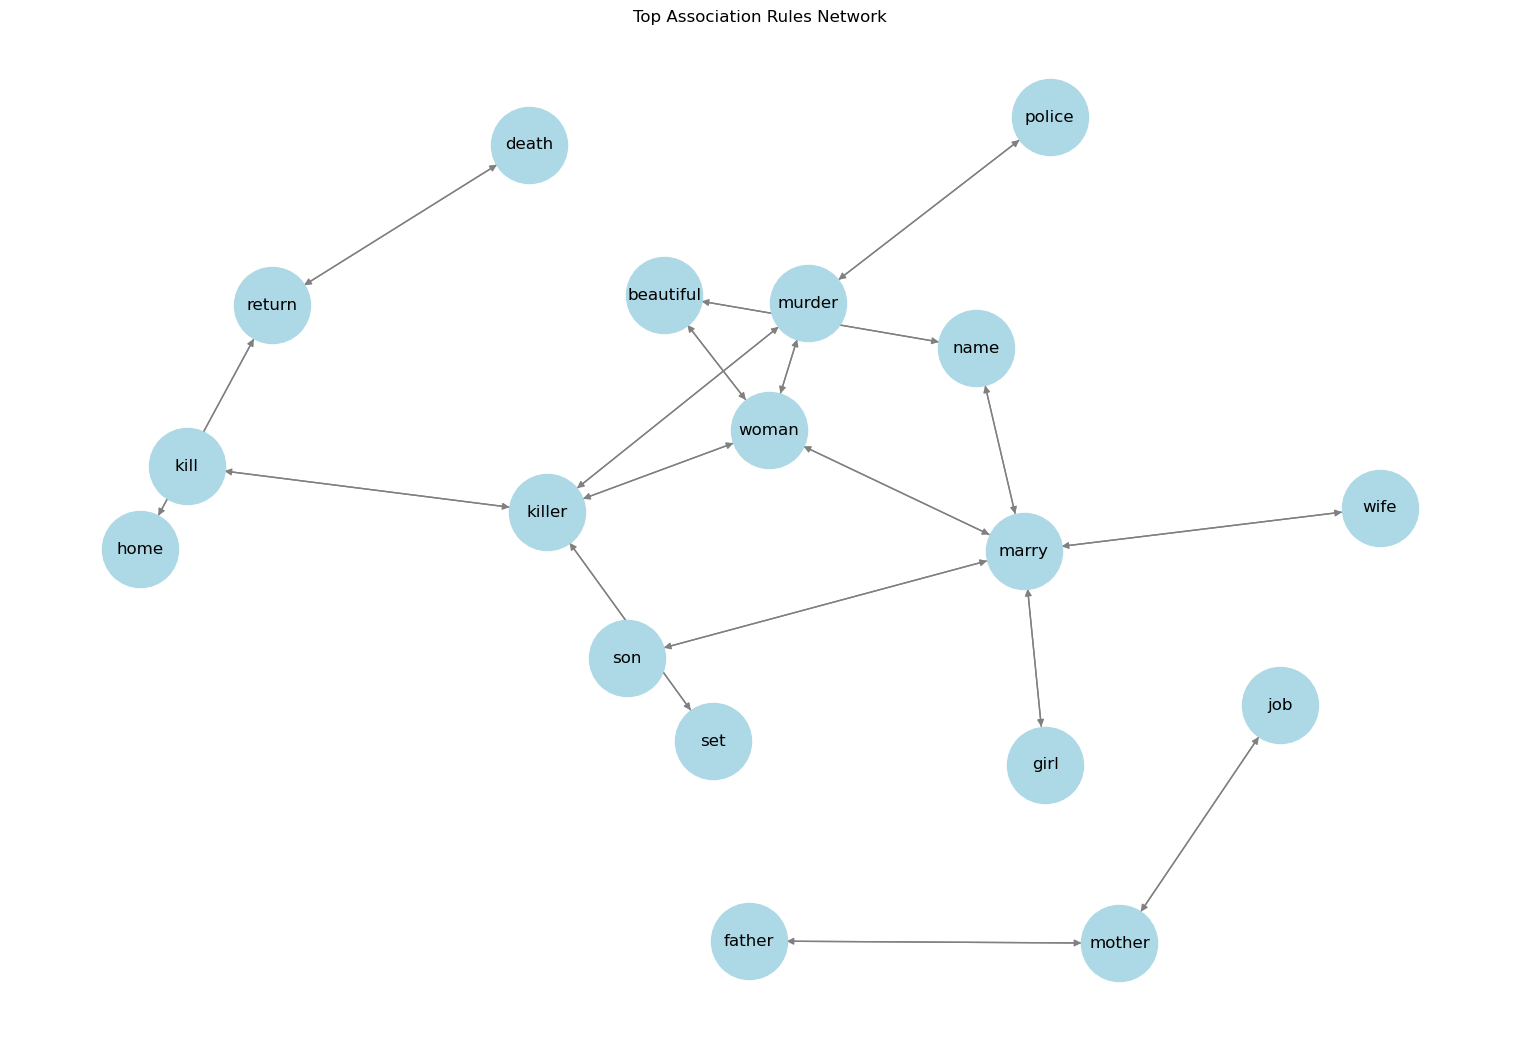

In [818]:
import networkx as nx

# Example: Use top 20 ARM rules (you can filter by lift or confidence)
from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=3.0)
rules = rules.sort_values('lift', ascending=False).head(20)

G = nx.DiGraph()

for _, row in rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=1.5)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', 
        edge_color='gray', font_size=12, arrows=True)
plt.title('Top Association Rules Network')
plt.show()


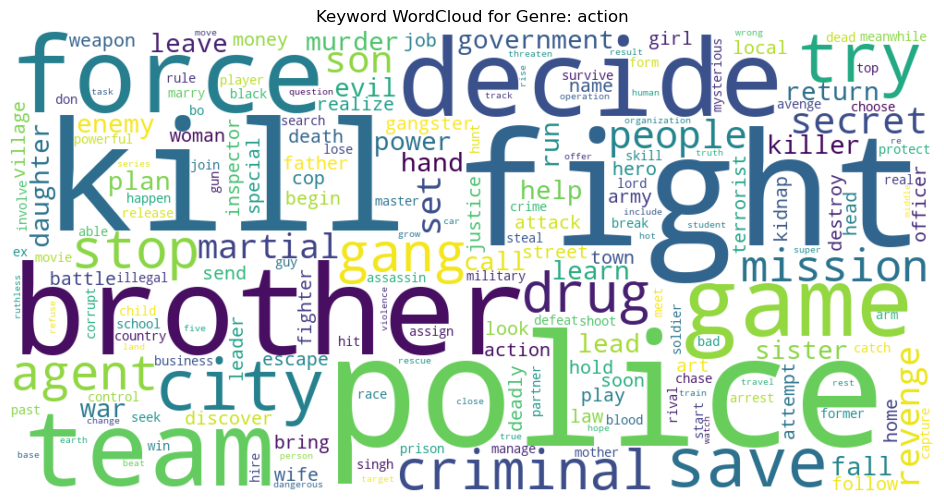

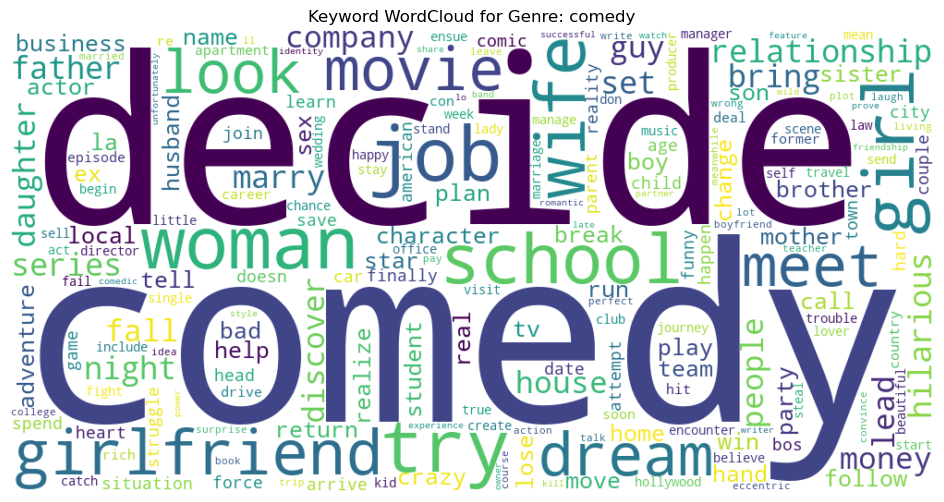

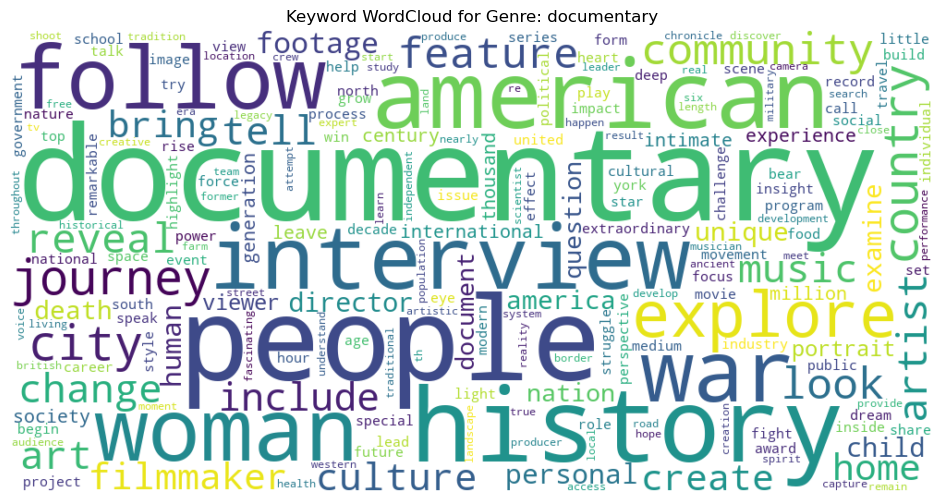

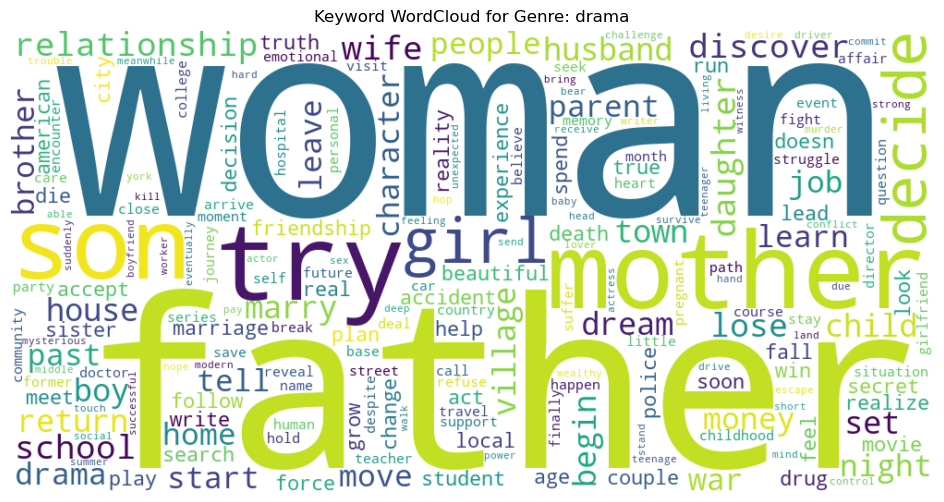

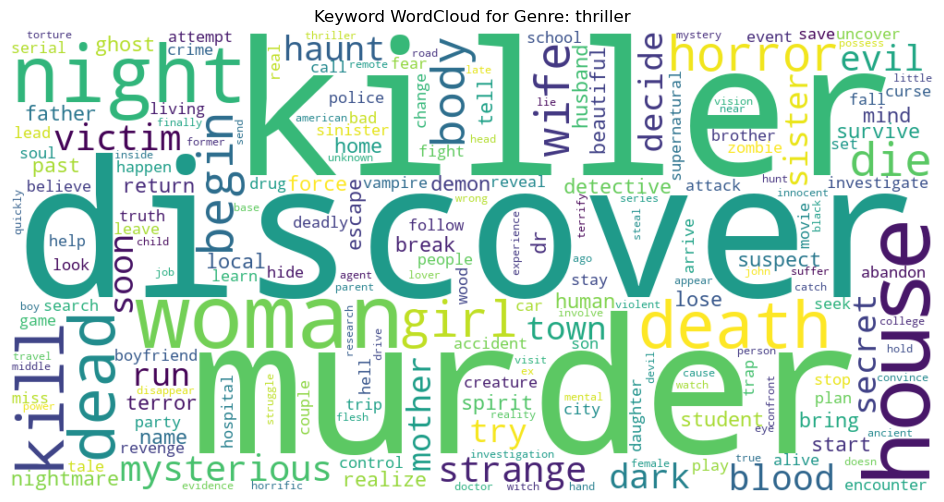

In [819]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

genres = df['Genre'].unique()

for genre in genres:
    # Extract keywords dictionaries for the genre and flatten keys to a list
    keyword_lists = df[df['Genre'] == genre]['keywords'].tolist()
    
    # Flatten list of dict keys into one list of keywords
    keywords = []
    for kw_dict in keyword_lists:
        keywords.extend(kw_dict.keys())
    
    # Join all keywords into one big string
    text = ' '.join(keywords)
    
    wordcloud = WordCloud(width=1000, height=500, background_color='white').generate(text)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Keyword WordCloud for Genre: {genre}')
    plt.show()


# DONT LOOK BELOW

# BOW MODELLING

In [820]:
X = description_bow_matrix
y = df["Genre"].values

In [821]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [822]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)


c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\Users\Admin\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\Admin\anaconda3\Lib\ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)


NameError: name 'train_test_split' is not defined

# BEFORE TRAINING

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

print("🔵 Logistic Regression Report")
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))
f1_log = f1_score(y_test, y_pred_log, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_log:.4f}")

🔵 Logistic Regression Report
              precision    recall  f1-score   support

      action       0.73      0.70      0.71       316
      comedy       0.59      0.59      0.59       309
 documentary       0.73      0.80      0.76       284
       drama       0.55      0.56      0.56       301
    thriller       0.73      0.69      0.71       290

    accuracy                           0.67      1500
   macro avg       0.67      0.67      0.67      1500
weighted avg       0.67      0.67      0.66      1500

🎯 Weighted F1 Score: 0.6650


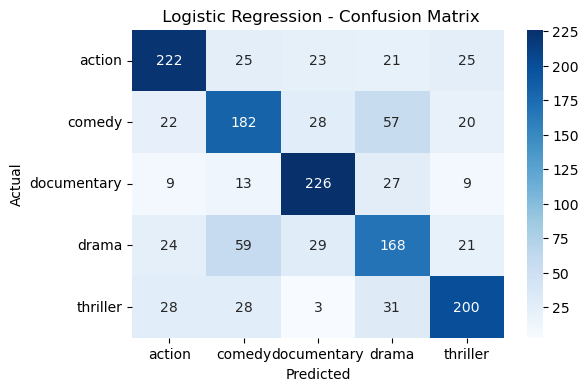

In [ ]:
cm_log = confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(" Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("🟢 Random Forest Report")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_rf:.4f}")


🟢 Random Forest Report
              precision    recall  f1-score   support

      action       0.63      0.67      0.65       316
      comedy       0.67      0.48      0.56       309
 documentary       0.70      0.85      0.77       284
       drama       0.52      0.58      0.55       301
    thriller       0.67      0.60      0.64       290

    accuracy                           0.64      1500
   macro avg       0.64      0.64      0.63      1500
weighted avg       0.64      0.64      0.63      1500

🎯 Weighted F1 Score: 0.6313


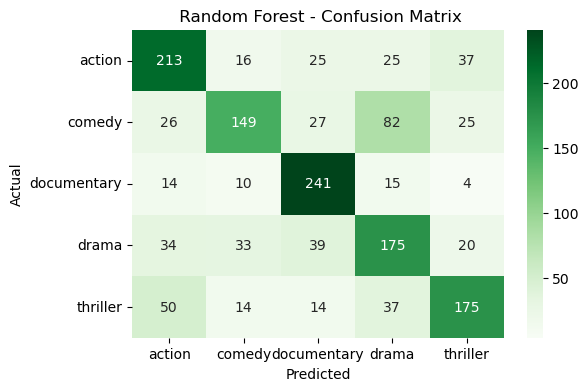

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title(" Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("🟡 Naive Bayes Report")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
f1_nb = f1_score(y_test, y_pred_nb, average='weighted')
print(f"🎯 Weighted F1 Score: {f1_nb:.4f}")

🟡 Naive Bayes Report
              precision    recall  f1-score   support

      action       0.75      0.69      0.72       316
      comedy       0.66      0.59      0.63       309
 documentary       0.71      0.86      0.78       284
       drama       0.54      0.54      0.54       301
    thriller       0.74      0.73      0.73       290

    accuracy                           0.68      1500
   macro avg       0.68      0.68      0.68      1500
weighted avg       0.68      0.68      0.68      1500

🎯 Weighted F1 Score: 0.6779


c:\Users\Admin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128993 (\N{LARGE YELLOW CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


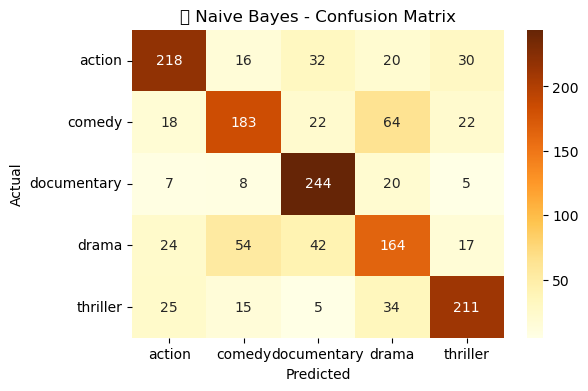

In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="YlOrBr", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("🟡 Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# AFTER TRAINING

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Feature selection
selector = SelectKBest(chi2, k=3900)  # you can change k=2000/4000 as needed
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)

# Plotting function for confusion matrix
def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

🔵 Logistic Regression
              precision    recall  f1-score   support

      action       0.74      0.72      0.73       300
      comedy       0.65      0.68      0.67       300
 documentary       0.80      0.80      0.80       300
       drama       0.59      0.58      0.59       300
    thriller       0.71      0.70      0.71       300

    accuracy                           0.70      1500
   macro avg       0.70      0.70      0.70      1500
weighted avg       0.70      0.70      0.70      1500

🎯 Weighted F1 Score: 0.6994


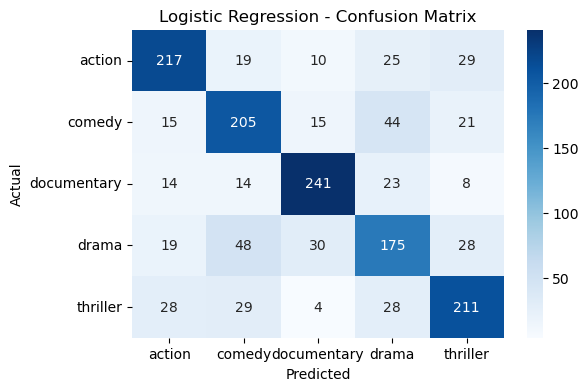

In [ ]:
print("🔵 Logistic Regression")

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, scoring='f1_weighted', cv=5)
grid_lr.fit(X_train_sel, y_train)
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_sel)

print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression - Confusion Matrix", "Blues", label_encoder.classes_)

🟢 Random Forest
              precision    recall  f1-score   support

      action       0.65      0.68      0.66       300
      comedy       0.65      0.50      0.57       300
 documentary       0.72      0.78      0.75       300
       drama       0.53      0.56      0.55       300
    thriller       0.67      0.71      0.69       300

    accuracy                           0.65      1500
   macro avg       0.65      0.65      0.64      1500
weighted avg       0.65      0.65      0.64      1500

🎯 Weighted F1 Score: 0.6429


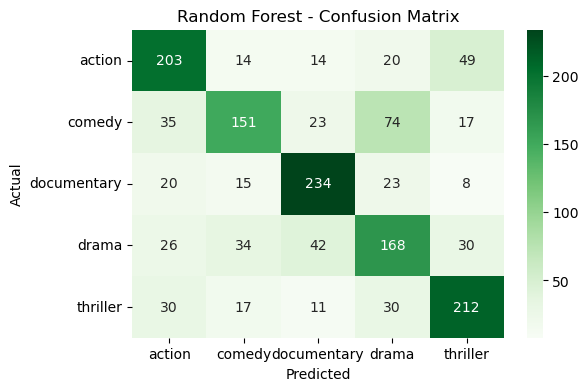

In [ ]:
# --- RANDOM FOREST ---

print("🟢 Random Forest")

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, scoring='f1_weighted', cv=5)
grid_rf.fit(X_train_sel, y_train)
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_sel)

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Confusion Matrix", "Greens", label_encoder.classes_)


🟡 Naive Bayes
              precision    recall  f1-score   support

      action       0.73      0.68      0.70       300
      comedy       0.67      0.64      0.66       300
 documentary       0.73      0.82      0.77       300
       drama       0.58      0.58      0.58       300
    thriller       0.72      0.72      0.72       300

    accuracy                           0.69      1500
   macro avg       0.69      0.69      0.69      1500
weighted avg       0.69      0.69      0.69      1500

🎯 Weighted F1 Score: 0.6868


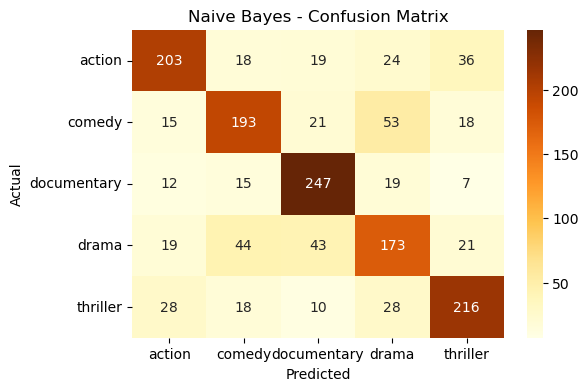

In [ ]:
# --- NAIVE BAYES ---

print("🟡 Naive Bayes")

param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}

grid_nb = GridSearchCV(MultinomialNB(), param_grid_nb, scoring='f1_weighted', cv=5)
grid_nb.fit(X_train_sel, y_train)
best_nb = grid_nb.best_estimator_
y_pred_nb = best_nb.predict(X_test_sel)

print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes - Confusion Matrix", "YlOrBr", label_encoder.classes_)


In [ ]:
print("\n📊 Model F1 Score Comparison")
print(f"Logistic Regression: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")
print(f"Random Forest     : {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")
print(f"Naive Bayes       : {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")



📊 Model F1 Score Comparison
Logistic Regression: 0.6994
Random Forest     : 0.6429
Naive Bayes       : 0.6868


# TFIDF MODELLING

In [ ]:
vectorizer = TfidfVectorizer(max_df=0.16, max_features=5000)
tfidf_X = vectorizer.fit_transform(description_string)
tfidf_X_vectorized = tfidf_X.toarray()

In [ ]:
print(tfidf_X_vectorized.max())

1.0


In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_X_vectorized, y_encoded, test_size=0.3, random_state=42)

def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


🔵 Logistic Regression
              precision    recall  f1-score   support

      action       0.74      0.76      0.75       409
      comedy       0.67      0.65      0.66       418
 documentary       0.76      0.81      0.78       402
       drama       0.57      0.56      0.57       388
    thriller       0.74      0.71      0.72       383

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000

🎯 Weighted F1 Score: 0.6976


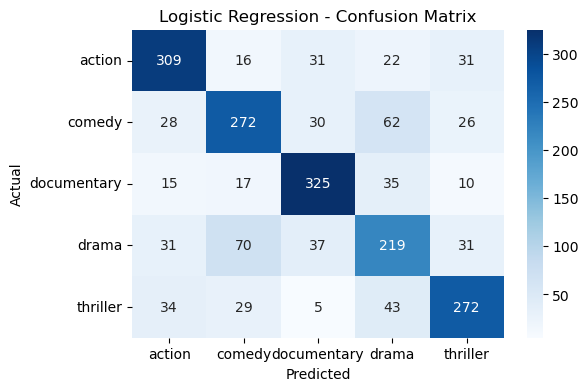

In [ ]:
print("🔵 Logistic Regression")

model_lr = LogisticRegression(max_iter=1000, class_weight='balanced')
model_lr.fit(X_train_tfidf, y_train)
y_pred_lr = model_lr.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_lr, "Logistic Regression - Confusion Matrix", "Blues", label_encoder.classes_)


🟣 Naive Bayes
              precision    recall  f1-score   support

      action       0.72      0.74      0.73       409
      comedy       0.75      0.52      0.62       418
 documentary       0.75      0.81      0.78       402
       drama       0.56      0.62      0.59       388
    thriller       0.69      0.75      0.72       383

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

🎯 Weighted F1 Score: 0.6861


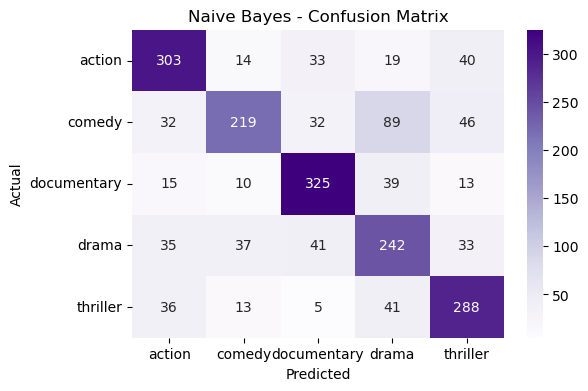

In [ ]:
print("🟣 Naive Bayes")

model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train)
y_pred_nb = model_nb.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_nb, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes - Confusion Matrix", "Purples", label_encoder.classes_)

🟢 Random Forest
              precision    recall  f1-score   support

      action       0.65      0.69      0.67       409
      comedy       0.64      0.46      0.54       418
 documentary       0.72      0.78      0.75       402
       drama       0.47      0.54      0.51       388
    thriller       0.67      0.66      0.67       383

    accuracy                           0.63      2000
   macro avg       0.63      0.63      0.63      2000
weighted avg       0.63      0.63      0.63      2000

🎯 Weighted F1 Score: 0.6254


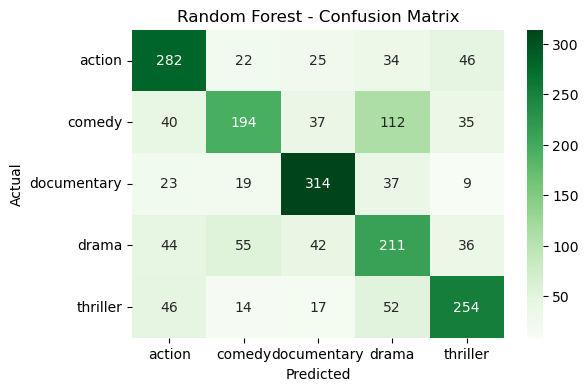

In [ ]:
print("🟢 Random Forest")

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train_tfidf, y_train)
y_pred_rf = model_rf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f"🎯 Weighted F1 Score: {f1_score(y_test, y_pred_rf, average='weighted'):.4f}")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest - Confusion Matrix", "Greens", label_encoder.classes_)

# AFTER TRAINING TFIDF

In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_X_vectorized, y_encoded, test_size=0.3, random_state=42)


selector = SelectKBest(chi2, k=3900)
X_train_sel = selector.fit_transform(X_train_tfidf, y_train)
X_test_sel = selector.transform(X_test_tfidf)

def plot_confusion_matrix(y_true, y_pred, title, cmap, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],       # Regularization strength
    'solver': ['liblinear', 'lbfgs'],   # Optimization solver
    'penalty': ['l2']                   # Regularization type (lbfgs only supports 'l2')
}

# Create the model
lr = LogisticRegression(max_iter=1000)

# Grid search using weighted F1 score and 5-fold CV
grid_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, 
                       scoring='f1_weighted', cv=5, verbose=1, n_jobs=-1)

# Fit the model using selected features (after SelectKBest)
grid_lr.fit(X_train_sel, y_train)

# Best model and predictions
best_lr = grid_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test_sel)

# Results
print("🔵 Best Logistic Regression Parameters:", grid_lr.best_params_)
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))
print(f"🎯 Best Weighted F1 Score: {f1_score(y_test, y_pred_lr, average='weighted'):.4f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
🔵 Best Logistic Regression Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
              precision    recall  f1-score   support

      action       0.75      0.72      0.74       316
      comedy       0.67      0.66      0.66       309
 documentary       0.74      0.83      0.79       284
       drama       0.61      0.60      0.60       301
    thriller       0.75      0.72      0.73       290

    accuracy                           0.70      1500
   macro avg       0.70      0.71      0.70      1500
weighted avg       0.70      0.70      0.70      1500

🎯 Best Weighted F1 Score: 0.7038
